# Аналіз ВІЛ/СНІД в Україні (2014-2024)

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [183]:
# Налаштування стилів графіків
plt.style.use('default')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

## 2. Завантаження та підготовка даних

In [184]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    data['Date'] = pd.to_datetime(data['Date'])
    print(f"Розмір датасету: {data.shape}")
    print("\nПерші 5 рядків:")
    print(data.head())
    return data

file_path = '/Users/konstantin/Documents/КПІ/ДИПЛОМ/CSV/hiv_ukraine_data_all.csv'
data = load_data(file_path)

Розмір датасету: (3437, 14)

Перші 5 рядків:
        Date            Region  New_HIV_Cases  HIV_Rate  New_AIDS_Cases  \
0 2014-01-01           Україна         1940.0       4.3           872.0   
1 2014-01-01              Крим          104.0       5.3            33.0   
2 2014-01-01         Вінницька           28.0       1.7            26.0   
3 2014-01-01         Волинська            9.0       0.9             8.0   
4 2014-01-01  Дніпропетровська          239.0       7.2           156.0   

   AIDS_Rate  AIDS_Deaths  Death_Rate  Sexual_Transmission  Heterosexual  \
0        1.9        274.0         0.6               1124.0        1105.0   
1        1.7         12.0         0.6                  NaN           NaN   
2        1.6          4.0         0.2                  NaN           NaN   
3        0.8          0.0         0.0                  NaN           NaN   
4        4.7         76.0         2.3                  NaN           NaN   

   Homosexual  Parenteral_Transmission  Other_T

In [185]:
# Фільтрація даних 
# додаємо нові два стовпці з обʼєднанимим новими випадками ВІЛ та СНІД
# формування окремого масиву без стовця "Україна", а також видалення регіонів з відсутніми даними

data['Total_Cases'] = data['New_HIV_Cases'] + data['New_AIDS_Cases']
data['Total_Cases_rate'] = data['HIV_Rate'] + data['AIDS_Rate']
filtered_data = data[data['Region'] != 'Україна'].copy()
excluded_regions = ['Крим', 'Севастополь', 'м. Севастополь']
filtered_data = filtered_data[~filtered_data['Region'].isin(excluded_regions)]

## 3. Візуалізація абсолютних показників випадків ВІЛ по регіонах

In [186]:
def plot_absolute_cases(data):
    """Кількість випадків ВІЛ-інфекції та СНІДу по регіонах (абсолютні значення)"""
    region_cases = data.groupby('Region')['Total_Cases'].sum().reset_index()
    region_cases = region_cases.sort_values('Total_Cases', ascending=False)
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='Total_Cases', y='Region', data=region_cases, palette='viridis')
    
    # Додавання значень на стовпці
    for p in ax.patches:
        ax.text(p.get_width() + 50, 
                p.get_y() + p.get_height()/2, 
                f'{int(p.get_width()):,}', 
                va='center', fontsize=10)
    
    plt.title('Кількість нових випадків ВІЛ-інфекції та СНІДу по регіонах України (2014-2024)')
    plt.xlabel('Кількість нових випадків (ВІЛ-інфекція + СНІД)')
    plt.ylabel('Регіон')
    plt.tight_layout()
    plt.savefig('hiv_aids_cases_by_region_all_years.png', dpi=300)
    plt.show()

In [187]:
def plot_relative_cases(data):
    """Рівень захворюваності по регіонах (на 100 тис. населення)"""
    region_rates = data.groupby('Region')['Total_Cases_rate'].mean().reset_index()
    region_rates = region_rates.sort_values('Total_Cases_rate', ascending=False)
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='Total_Cases_rate', y='Region', data=region_rates, palette='viridis')
    
    # Додавання значень на стовпці
    for p in ax.patches:
        ax.text(p.get_width() + 0.1, 
                p.get_y() + p.get_height()/2, 
                f'{p.get_width():.1f}', 
                va='center', fontsize=10)
    
    plt.title('Середній рівень захворюваності на ВІЛ-інфекцію та СНІД по регіонах України (2014-2024)\n(кількість на 100 тис. населення)')
    plt.xlabel('Кількість випадків на 100 тис. населення')
    plt.ylabel('Регіон')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('hiv_aids_relative_cases_by_region.png', dpi=300)
    plt.show()

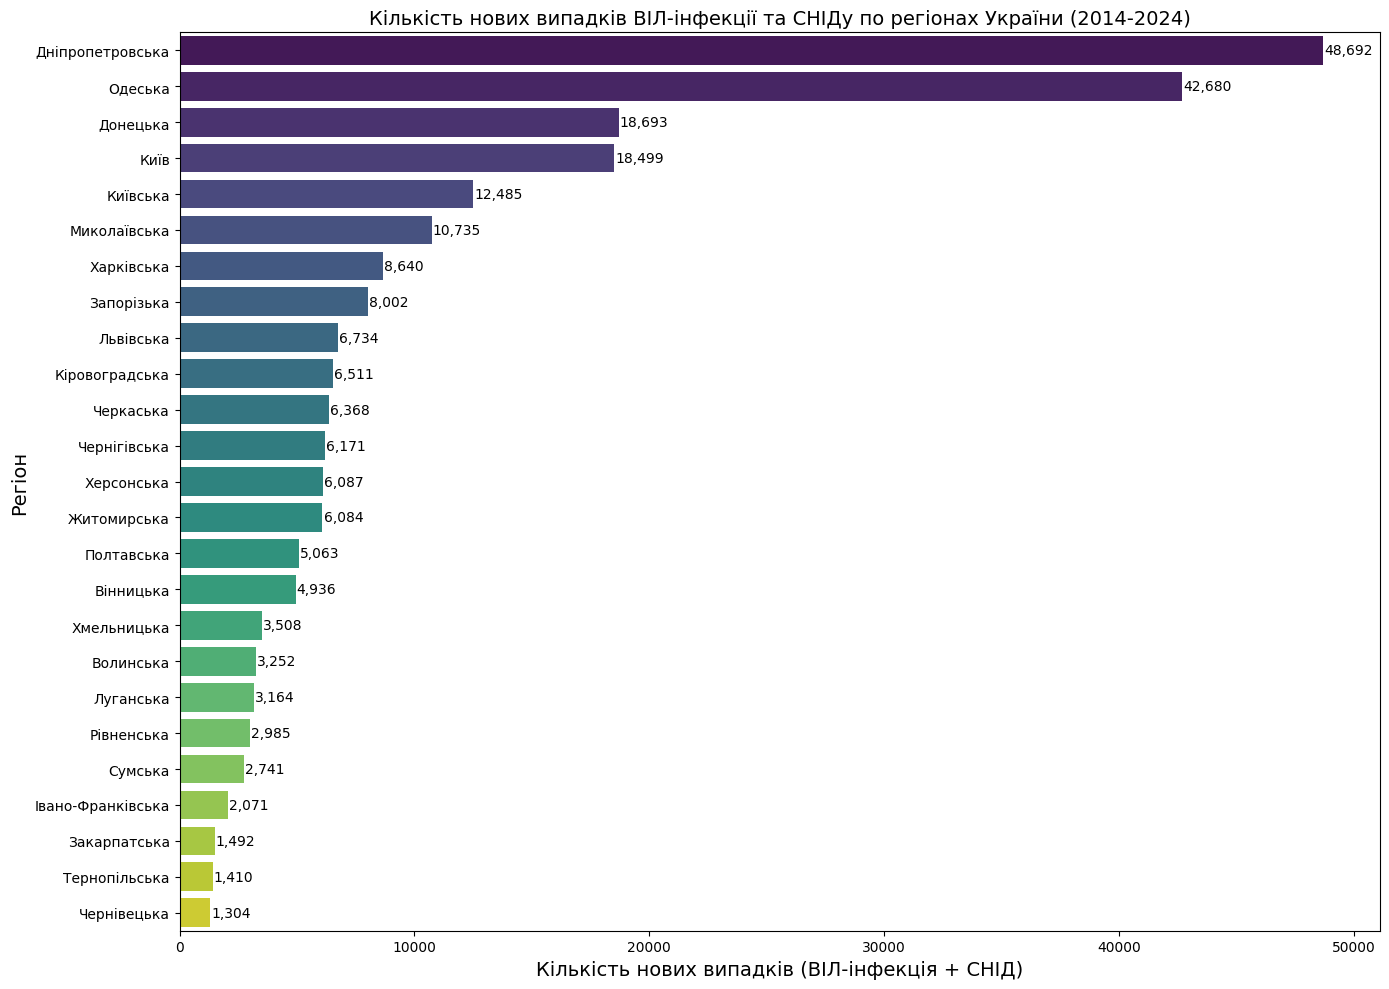

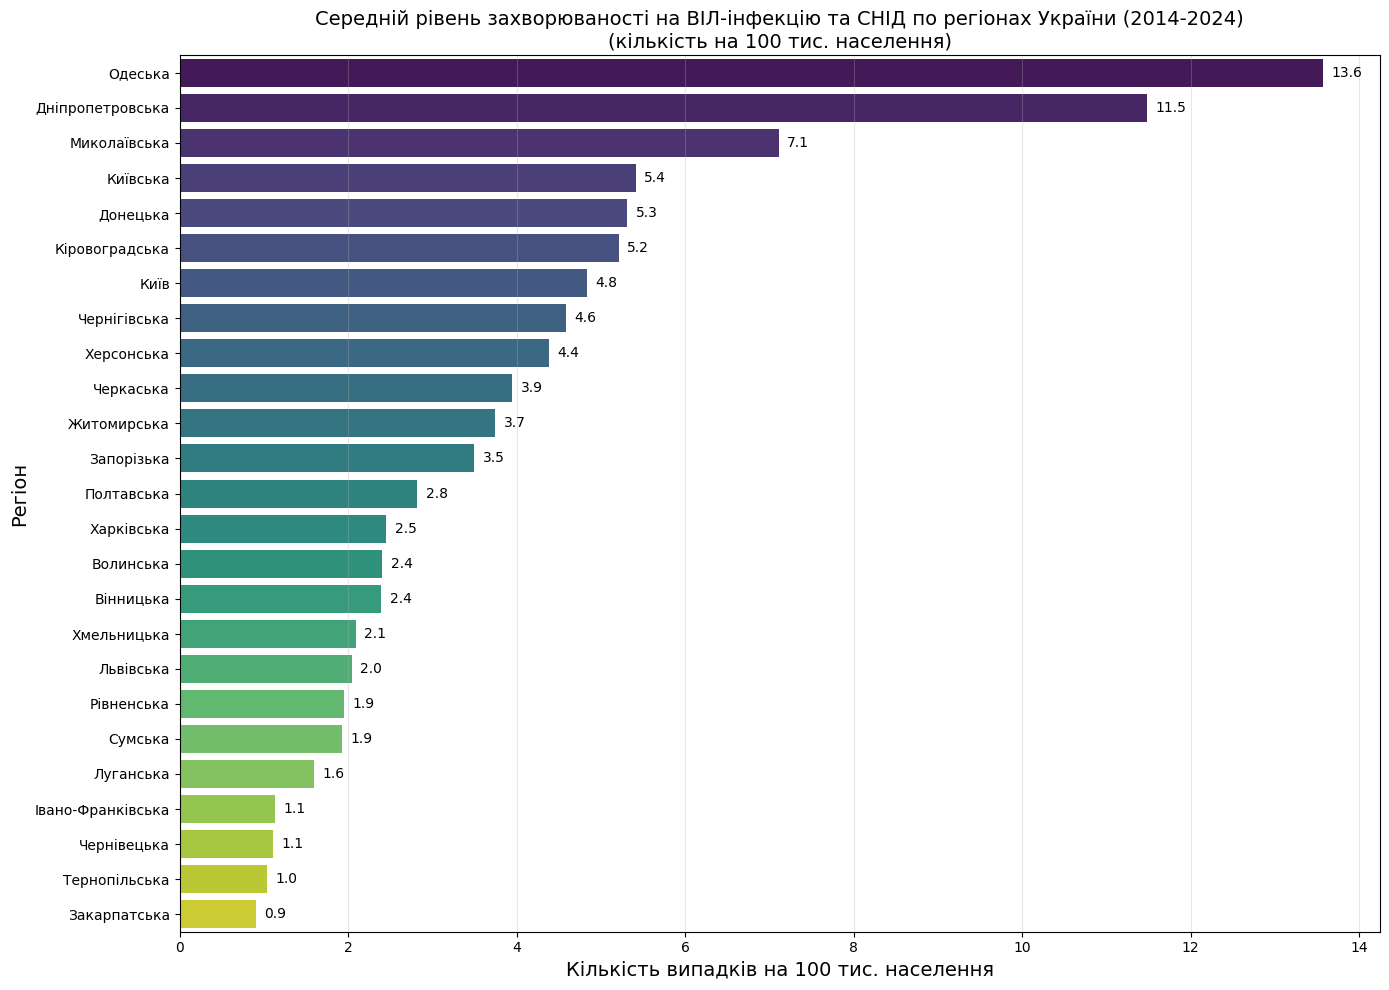

In [188]:
plot_absolute_cases(filtered_data)
plot_relative_cases(filtered_data)

## 4. Теплова карта захворюваності по місяцях та регіонах

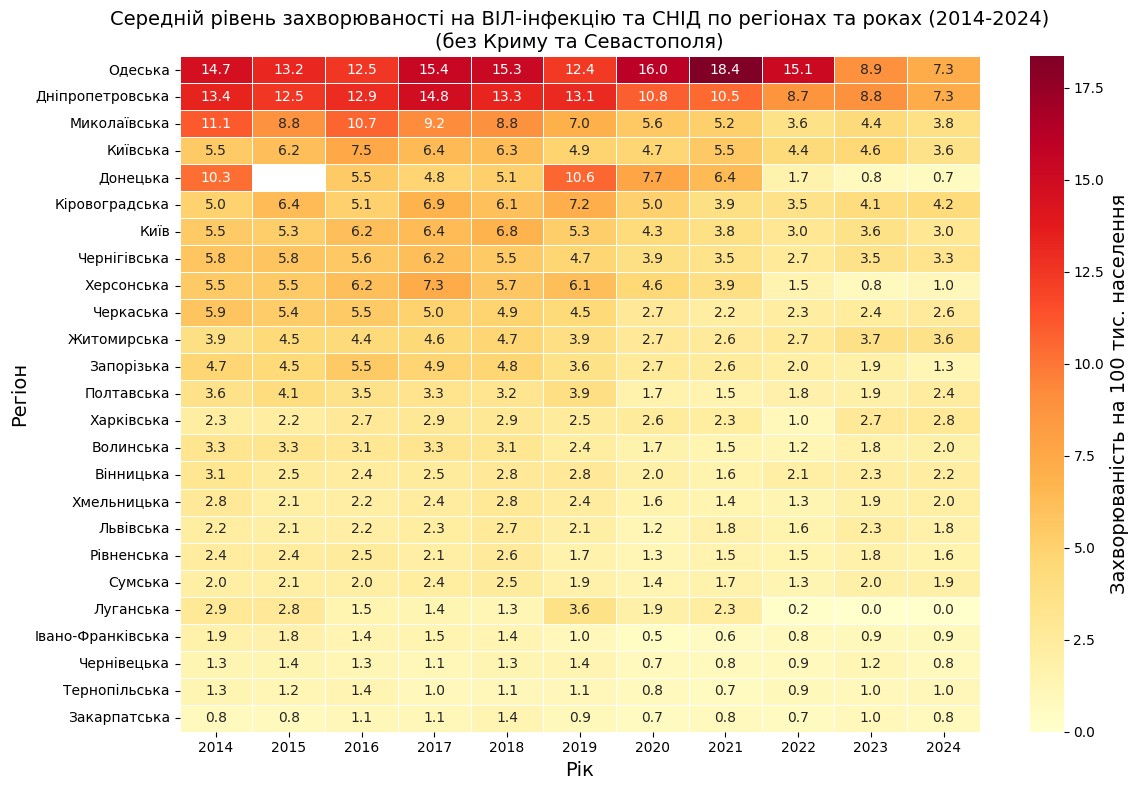

In [189]:
def plot_hiv_heatmap(data):
    """Теплова карта захворюваності по регіонах за роками"""
    # Додаємо стовпець з роком
    data['Year'] = data['Date'].dt.year
    
    # Створюємо таблицю з середніми значеннями за роками та регіонами
    pivot = data.pivot_table(index='Region', 
                            columns='Year', 
                            values='Total_Cases_rate', 
                            aggfunc='mean')
    
    # Сортуємо регіони за середньорічним рівнем захворюваності
    pivot['Average'] = pivot.mean(axis=1)
    pivot = pivot.sort_values('Average', ascending=False)
    pivot = pivot.drop(columns='Average')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, 
                annot=True, 
                cmap='YlOrRd', 
                fmt='.1f', 
                linewidths=.5,
                cbar_kws={'label': 'Захворюваність на 100 тис. населення'})
    
    plt.title('Середній рівень захворюваності на ВІЛ-інфекцію та СНІД по регіонах та роках (2014-2024)\n(без Криму та Севастополя)')
    plt.xlabel("Рік")
    plt.ylabel("Регіон")
    plt.tight_layout()
    plt.savefig('hiv_aids_rate_heatmap_by_years.png', dpi=300)
    plt.show()

plot_hiv_heatmap(filtered_data)

In [190]:
def plot_monthly_trend(data):
    df = data[data['Region'] == 'Україна'].copy()
    df['Month'] = df['Date'].dt.month
    
    monthly_avg = df.groupby('Month')['Total_Cases_rate'].mean().reset_index()
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=monthly_avg, x='Month', y='Total_Cases_rate', marker='o')
    
    plt.title('Середньомісячна захворюваність на ВІЛ-інфекцію та СНІД (2014-2024)')
    plt.xlabel('Місяць')
    plt.ylabel('Захворюваність на 100 тис.')
    plt.xticks(range(1,13), ['Січ', 'Лют', 'Бер', 'Кві', 'Тра', 'Чер', 
                            'Лип', 'Сер', 'Вер', 'Жов', 'Лис', 'Гру'])
    plt.grid(True, alpha=0.3)
    plt.ylim(1, max(monthly_avg['Total_Cases_rate'])*1.1)
    plt.tight_layout()
    plt.savefig('hiv_aids_monthly_trend.png', dpi=300)
    plt.show()

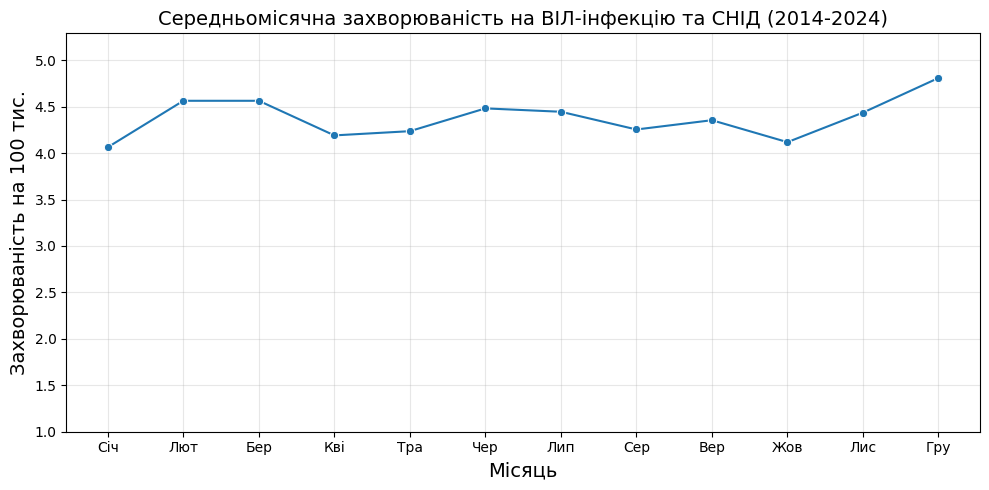

In [191]:
plot_monthly_trend(data)

## 5. Аналіз шляхів передачі ВІЛ

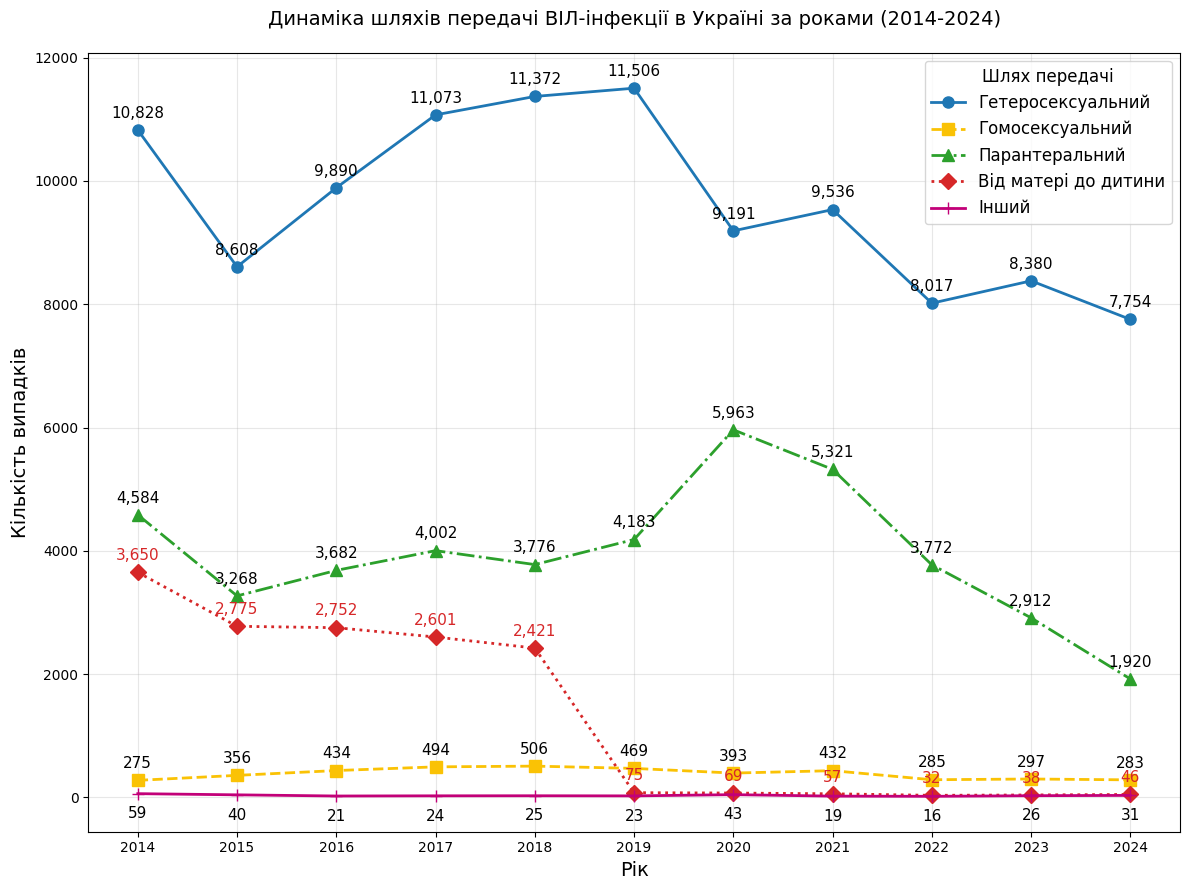

In [307]:
def plot_yearly_transmission(data):
    """Лінійний графік динаміки шляхів передачі ВІЛ-інфекції за роками"""
    # Групуємо дані за роками
    yearly_data = data[data['Region'] == 'Україна'].copy()
    yearly_data['Year'] = yearly_data['Date'].dt.year
    transmission_cols = ['Heterosexual', 'Homosexual', 'Parenteral_Transmission', 'Children_HIV+', 'Other_Transmission']
    yearly_trans = yearly_data.groupby('Year')[transmission_cols].sum().reset_index()
    
    # Підготовка стилю графіка
    plt.figure(figsize=(12, 9))
    
    # Кольори для ліній
    colors = ['#1f77b4', '#FAC205', '#2ca02c', '#d62728', '#C20078']
    line_styles = ['-', '--', '-.', ':', '-']
    markers = ['o', 's', '^', 'D', '+']
    
    # Малюємо лінії для кожного шляху передачі
    for i, col in enumerate(transmission_cols):
        plt.plot(yearly_trans['Year'], yearly_trans[col], 
                label=col, 
                color=colors[i],
                linestyle=line_styles[i],
                marker=markers[i],
                linewidth=2,
                markersize=8)
        
        # Додаємо значення над точками
        for year, value in zip(yearly_trans['Year'], yearly_trans[col]):
            plt.text(year, 
                     value + 150 if col != 'Other_Transmission' else (value - 450), 
                     f'{int(value):,}', 
                     ha='center', va='bottom', 
                     fontsize=11, 
                     color='black' if col != 'Children_HIV+' else '#d62728')
    
    # Налаштування графіка
    plt.title('Динаміка шляхів передачі ВІЛ-інфекції в Україні за роками (2014-2024)', pad=20)
    plt.xlabel('Рік')
    plt.ylabel('Кількість випадків')
    plt.xticks(yearly_trans['Year'])
    plt.grid(True, alpha=0.3)
    legend_labels = [
        "Гетеросексуальний",
        "Гомосексуальний",
        "Парантеральний",
        "Від матері до дитини",
        "Інший"]
    plt.legend(legend_labels, fontsize=12, title='Шлях передачі', title_fontsize=12)
    
    # Зберігаємо графік
    plt.tight_layout()
    plt.savefig('hiv_transmission_yearly_lines.png', dpi=300)
    plt.show()

# Виклик функції
plot_yearly_transmission(data)

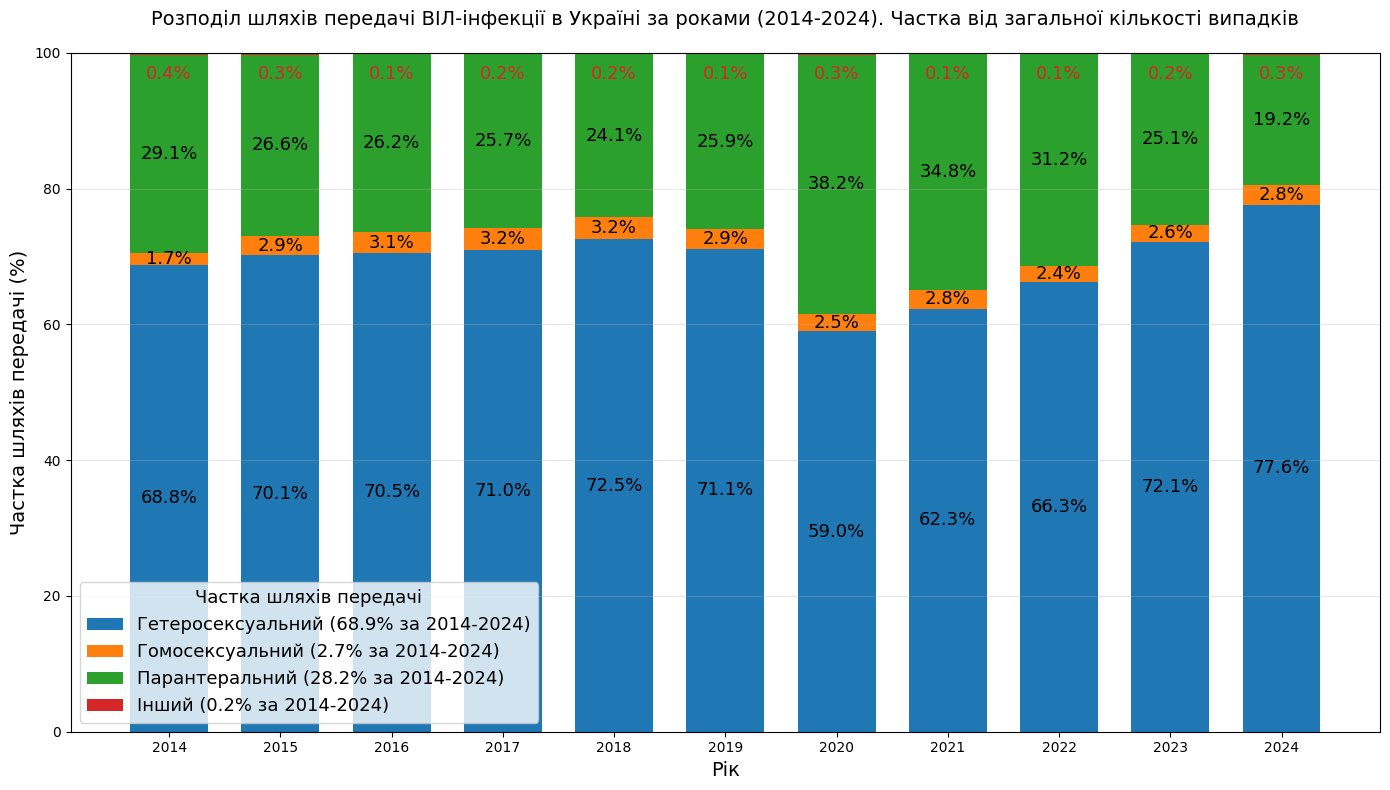

In [319]:
def plot_transmission_stacked_bar(data):
    """Стовпчастий графік з накопиченням: частка шляхів передачі ВІЛ за роками (2014-2024)"""
    
    # Фільтруємо дані для України та групуємо за роками
    yearly_data = data[data['Region'] == 'Україна'].copy()
    yearly_data['Year'] = yearly_data['Date'].dt.year
    
    transmission_cols = ['Heterosexual', 'Homosexual', 'Parenteral_Transmission', 'Other_Transmission']
    yearly_trans = yearly_data.groupby('Year')[transmission_cols].sum().reset_index()
    
    # Обчислюємо загальну кількість випадків за весь період (2014-2024)
    total_cases = yearly_trans[transmission_cols].sum().sum()
    
    # Обчислюємо частку кожного шляху передачі за весь період
    total_percentages = {
        'Heterosexual': yearly_trans['Heterosexual'].sum() / total_cases * 100,
        'Homosexual': yearly_trans['Homosexual'].sum() / total_cases * 100,
        'Parenteral': yearly_trans['Parenteral_Transmission'].sum() / total_cases * 100,
        'Other': yearly_trans['Other_Transmission'].sum() / total_cases * 100
    }
    
    # Обчислюємо відсоткову частку кожного шляху передачі за рік (для графіка)
    yearly_trans['Total'] = yearly_trans[transmission_cols].sum(axis=1)
    for col in transmission_cols:
        yearly_trans[f'{col}_percent'] = (yearly_trans[col] / yearly_trans['Total']) * 100
    
    # Підготовка даних для графіка
    years = yearly_trans['Year']
    percentages = {
        'Heterosexual': yearly_trans['Heterosexual_percent'],
        'Homosexual': yearly_trans['Homosexual_percent'],
        'Parenteral': yearly_trans['Parenteral_Transmission_percent'],
        'Other': yearly_trans['Other_Transmission_percent']
    }
    
    # Кольори для кожного шляху передачі
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Створення графіка
    plt.figure(figsize=(14, 8))
    
    # Базовий рівень для накопичення
    bottom = np.zeros(len(years))
    
    # Додаємо кожен шлях передачі до стовпців
    for i, (label, percent) in enumerate(percentages.items()):
        plt.bar(years, percent, bottom=bottom, label=label, color=colors[i], width=0.7)
        bottom += percent
    
    # Додаємо підписи значень
    for year in years:
        current_bottom = 0
        for col in transmission_cols:
            percent = yearly_trans.loc[yearly_trans['Year'] == year, f'{col}_percent'].values[0]
            plt.text(year, 
                     (current_bottom + percent/2) if col != 'Other_Transmission' else (current_bottom + percent/2 - 3), 
                     f'{percent:.1f}%', 
                     ha='center', va='center', 
                     color='black' if col != 'Other_Transmission' else '#d62728', 
                     fontsize=13)
            current_bottom += percent
    
    plt.title('Розподіл шляхів передачі ВІЛ-інфекції в Україні за роками (2014-2024). Частка від загальної кількості випадків', fontsize=14, pad=20)
    plt.xlabel('Рік')
    plt.ylabel('Частка шляхів передачі (%)')
    plt.xticks(years)
    plt.ylim(0, 100)
    plt.grid(True, axis='y', alpha=0.3)
    
    # Оновлена легенда із загальною часткою за 2014-2024
    legend_labels = [
        f"Гетеросексуальний ({total_percentages['Heterosexual']:.1f}% за 2014-2024)",
        f"Гомосексуальний ({total_percentages['Homosexual']:.1f}% за 2014-2024)",
        f"Парантеральний ({total_percentages['Parenteral']:.1f}% за 2014-2024)",
        f"Інший ({total_percentages['Other']:.1f}% за 2014-2024)"
    ]
    plt.legend(legend_labels, title='Частка шляхів передачі', title_fontsize=13, fontsize=13)
    
    plt.tight_layout()
    plt.savefig('hiv_transmission_stacked_bar_total.png', dpi=300)
    plt.show()

plot_transmission_stacked_bar(data)

## 6. Аналіз часових рядів

### 6.1 Абсолютні значення

In [193]:
def plot_time_series(data):
    """Аналіз часових рядів: абсолютні показники"""
    ts_data = data[data['Region'] == 'Україна'].set_index('Date')
    
    plt.figure(figsize=(14, 10))
    
    # Графік ВІЛ та СНІД
    plt.subplot(2, 1, 1)
    plt.plot(ts_data.index, ts_data['Total_Cases'], 
             label='Фактичні дані', linewidth=1.5)
    model = ExponentialSmoothing(ts_data['Total_Cases'], trend='add').fit(smoothing_level=0.3)
    plt.plot(ts_data.index, model.fittedvalues, 'r--',
             label='Експ. згладжування (α=0.3)', linewidth=2)
    plt.title('Динаміка нових випадків ВІЛ-інфекції та СНІДу в Україні (2014-2024)')
    plt.ylabel('Кількість випадків')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Графік смертей від СНІДу
    plt.subplot(2, 1, 2)
    plt.plot(ts_data.index, ts_data['AIDS_Deaths'], 
             label='Фактичні дані', linewidth=1.5)
    model = ExponentialSmoothing(ts_data['AIDS_Deaths'], trend='add').fit(smoothing_level=0.3)
    plt.plot(ts_data.index, model.fittedvalues, 'r--',
             label='Експ. згладжування (α=0.3)', linewidth=2)
    plt.title('Динаміка кількості смертей від СНІДу в Україні (2014-2024)')
    plt.xlabel('Рік')
    plt.ylabel('Кількість випадків')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('hiv_aids_time_series_all_years.png', dpi=300)
    plt.show()

### 6.2 Відносні значення

In [194]:
def plot_relative_time_series(data):
    """Аналіз часових рядів: відносні показники"""
    ts_data = data[data['Region'] == 'Україна'].set_index('Date')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Графік ВІЛ та СНІД
    ax1.plot(ts_data.index, ts_data['Total_Cases_rate'], 
             label='Фактичні дані', linewidth=1.5)
    model = ExponentialSmoothing(ts_data['Total_Cases_rate'], trend='add').fit(smoothing_level=0.3)
    ax1.plot(ts_data.index, model.fittedvalues, 'r--',
             label='Експ. згладжування (α=0.3)', linewidth=2)
    ax1.set_title('Динаміка захворюваності на ВІЛ-інфекцію та СНІД в Україні (2014-2024)\n(кількість на 100 тис. населення)')
    ax1.set_ylabel('Кількість на 100 тис.')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Графік смертей від СНІД
    ax2.plot(ts_data.index, ts_data['Death_Rate'], 
             label='Фактичні дані', linewidth=1.5)
    model = ExponentialSmoothing(ts_data['Death_Rate'], trend='add').fit(smoothing_level=0.3)
    ax2.plot(ts_data.index, model.fittedvalues, 'r--',
             label='Експ. згладжування (α=0.3)', linewidth=2)
    ax2.set_title('Динаміка смертей від СНІДу в Україні (2014-2024)\n(кількість на 100 тис. населення)')
    ax2.set_xlabel('Рік')
    ax2.set_ylabel('Кількість на 100 тис.')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('hiv_aids_relative_dynamics.png', dpi=300)
    plt.show()

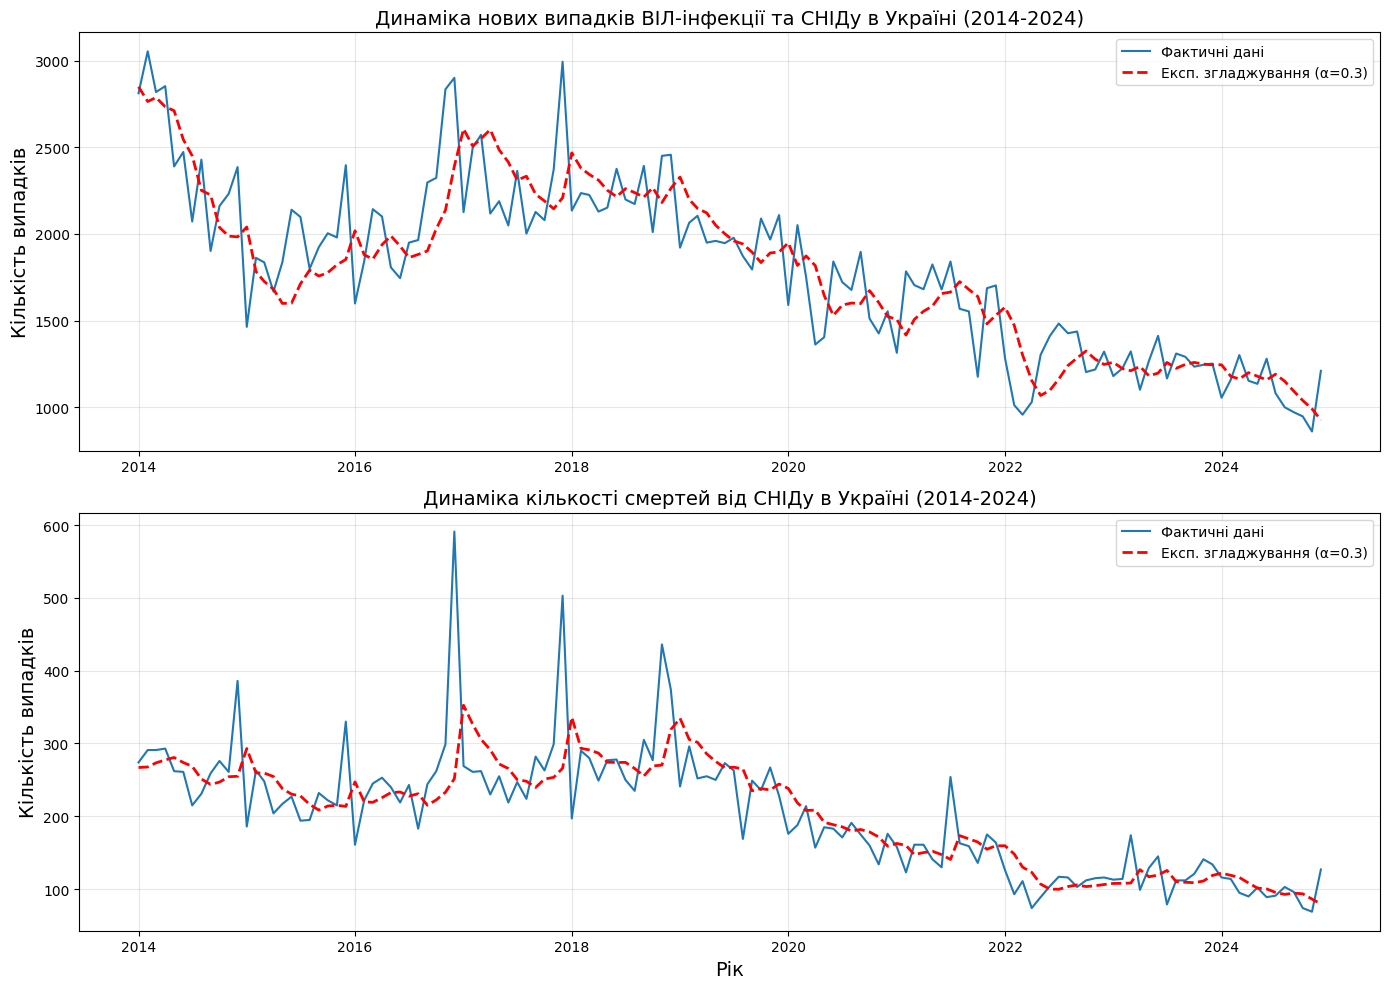

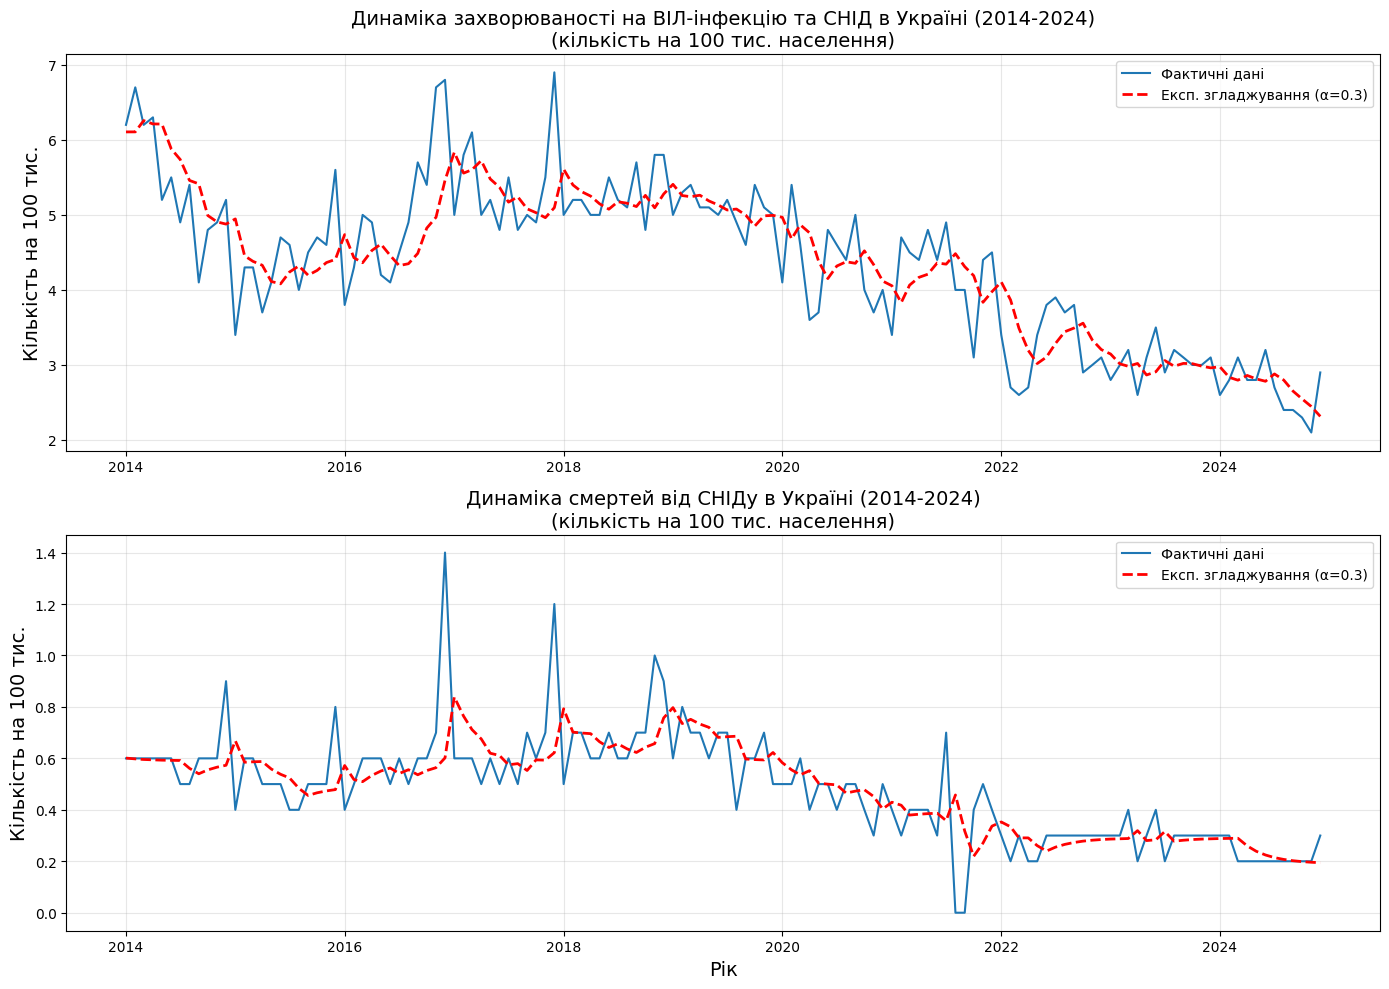

In [195]:
plot_time_series(data)
plot_relative_time_series(data)

In [250]:
def plot_yearly_cases_deaths(data):
    """Стовпчикова діаграма кількості випадків ВІЛ-інфекції, СНІДу та смертей від СНІДу за роками з відсотковими змінами"""
    # Групуємо дані за роками
    yearly_data = data[data['Region'] == 'Україна'].copy()
    yearly_data['Year'] = yearly_data['Date'].dt.year
    yearly_stats = yearly_data.groupby('Year').agg({
        'New_HIV_Cases': 'sum',
        'New_AIDS_Cases': 'sum',
        'AIDS_Deaths': 'sum'
    }).reset_index()
    
    # Обчислюємо відсоткові зміни порівняно з попереднім роком
    yearly_stats['HIV_Change'] = yearly_stats['New_HIV_Cases'].pct_change() * 100
    yearly_stats['AIDS_Change'] = yearly_stats['New_AIDS_Cases'].pct_change() * 100
    yearly_stats['Deaths_Change'] = yearly_stats['AIDS_Deaths'].pct_change() * 100
    
    # Підготовка даних для графіка
    years = yearly_stats['Year']
    hiv_cases = yearly_stats['New_HIV_Cases']
    aids_cases = yearly_stats['New_AIDS_Cases']
    deaths = yearly_stats['AIDS_Deaths']
    
    # Ширина стовпців
    bar_width = 0.25
    r1 = np.arange(len(years))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Створення графіка
    plt.figure(figsize=(14, 8))
    bars1 = plt.bar(r1, hiv_cases, color='#069AF3', width=bar_width, label='Нові випадки ВІЛ-інфекції')
    bars2 = plt.bar(r2, aids_cases, color='#7BC8F6', width=bar_width, label='Нові випадки СНІДу')
    bars3 = plt.bar(r3, deaths, color='#FFA500', width=bar_width, label='Смерті від СНІДу')
    
    # Додавання значень над стовпцями
    for i, (bars, changes) in enumerate(zip([bars1, bars2, bars3], 
                                         ['HIV_Change', 'AIDS_Change', 'Deaths_Change'])):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            # Основне значення
            plt.text(bar.get_x() + bar.get_width()/2., height+350,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=11)
            
            # Відсоткова зміна (починаємо з другого року)
            if j > 0:
                change = yearly_stats.at[j, changes]
                if not np.isnan(change):
                    change_text = f"{'+' if change >= 0 else ''}{change:.1f}%"
                    plt.text(bar.get_x() + bar.get_width()/2., height+350, 
                            change_text,
                            ha='center', va='top', fontsize=9,
                            color='red' if change > 0 else 'green')
    
    plt.title('Кількість випадків ВІЛ-інфекції, СНІДу та смертей від СНІДу в Україні за роками (2014-2024)\nЗ відсотковими змінами порівняно з попереднім роком')
    plt.xlabel('Рік')
    plt.ylabel('Кількість випадків')
    plt.xticks([r + bar_width for r in range(len(years))], years)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    
    # Збільшуємо нижній відступ, щоб було місце для відсоткових змін
    plt.subplots_adjust(bottom=0.15)
    
    plt.tight_layout()
    plt.savefig('hiv_aids_deaths_yearly_bars_with_changes.png', dpi=300)
    plt.show()

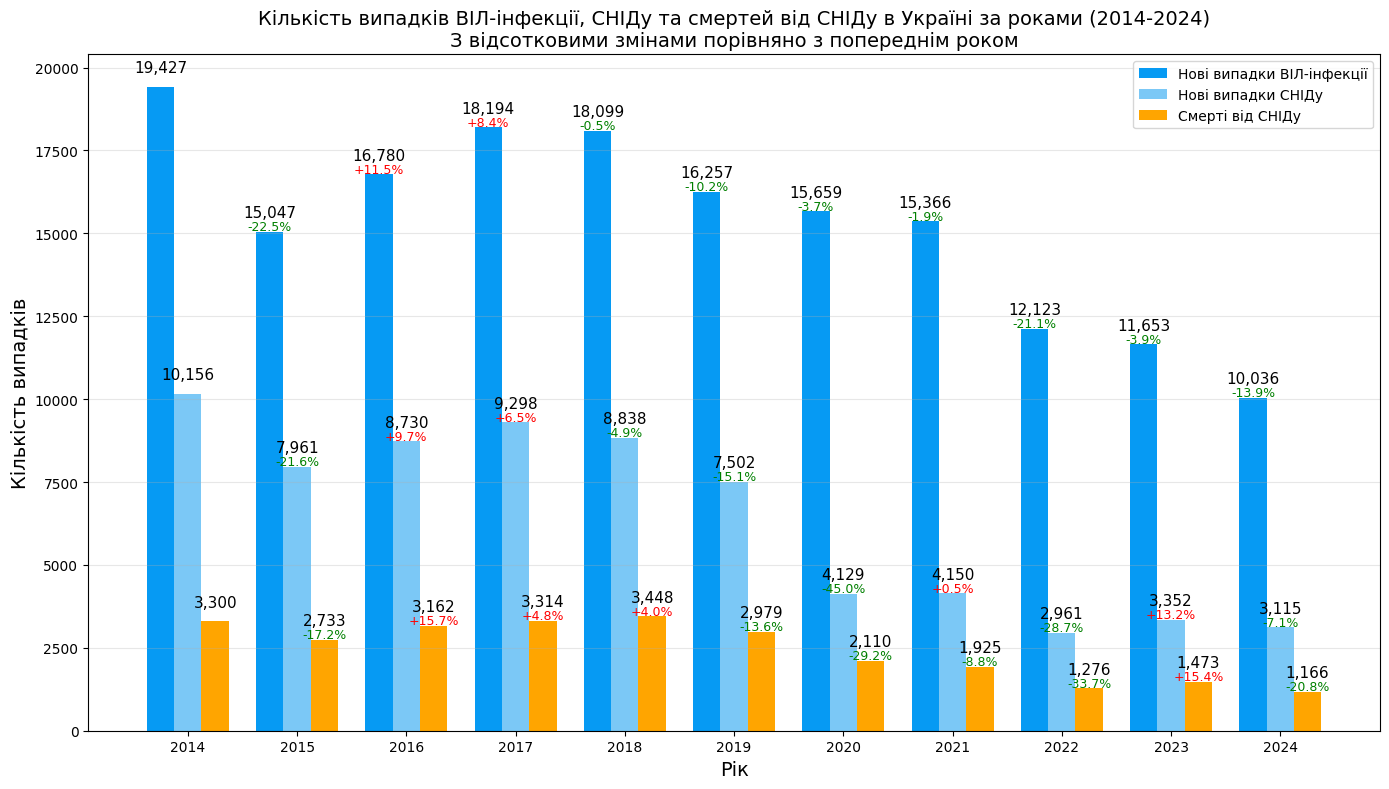

In [251]:
plot_yearly_cases_deaths(data)

In [256]:
def plot_yearly_rel_cases_deaths(data):
    """Стовпчикова діаграма загальної захворюваності на ВІЛ-інфекцію, СНІД та смертність від СНІДу за роками"""
    # Групуємо дані за роками
    yearly_data = data[data['Region'] == 'Україна'].copy()
    yearly_data['Year'] = yearly_data['Date'].dt.year
    yearly_stats = yearly_data.groupby('Year').agg({
        'HIV_Rate': 'sum',
        'AIDS_Rate': 'sum',
        'Death_Rate': 'sum'
    }).reset_index()

    yearly_stats['HIV_Change'] = yearly_stats['HIV_Rate'].pct_change() * 100
    yearly_stats['AIDS_Change'] = yearly_stats['AIDS_Rate'].pct_change() * 100
    yearly_stats['Deaths_Change'] = yearly_stats['Death_Rate'].pct_change() * 100
    
    # Підготовка даних для графіка
    years = yearly_stats['Year']
    hiv_cases = yearly_stats['HIV_Rate']
    aids_cases = yearly_stats['AIDS_Rate']
    deaths = yearly_stats['Death_Rate']
    
    # Ширина стовпців
    bar_width = 0.25
    r1 = np.arange(len(years))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Створення графіка
    plt.figure(figsize=(14, 8))
    bars1 = plt.bar(r1, hiv_cases, color='#069AF3', width=bar_width, label='Захворюваність на ВІЛ-інфекцію')
    bars2 = plt.bar(r2, aids_cases, color='#7BC8F6', width=bar_width, label='Захворюваність на СНІД')
    bars3 = plt.bar(r3, deaths, color='#FFA500', width=bar_width, label='Смертність від СНІДу')
    
   # Додавання значень над стовпцями
    for i, (bars, changes) in enumerate(zip([bars1, bars2, bars3], 
                                         ['HIV_Change', 'AIDS_Change', 'Deaths_Change'])):
        for j, bar in enumerate(bars):
            height = bar.get_height()
            # Основне значення
            plt.text(bar.get_x() + bar.get_width()/2., height+0.8,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=11)
            
            # Відсоткова зміна (починаємо з другого року)
            if j > 0:
                change = yearly_stats.at[j, changes]
                if not np.isnan(change):
                    change_text = f"{'+' if change >= 0 else ''}{change:.1f}%"
                    plt.text(bar.get_x() + bar.get_width()/2., height+0.8, 
                            change_text,
                            ha='center', va='top', fontsize=9,
                            color='red' if change > 0 else 'green')
    
    plt.title('Загальна захворюваність на ВІЛ-інфекцію, СНІД та смертність від СНІДу в Україні (на 100 000 населення) (2014-2024)')
    plt.xlabel('Рік')
    plt.ylabel('Загальна захворюваність/смертність (осіб на 100 000 населення)')
    plt.xticks([r + bar_width for r in range(len(years))], years)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('hiv_aids_deaths_rel_yearly_bars.png', dpi=300)
    plt.show()

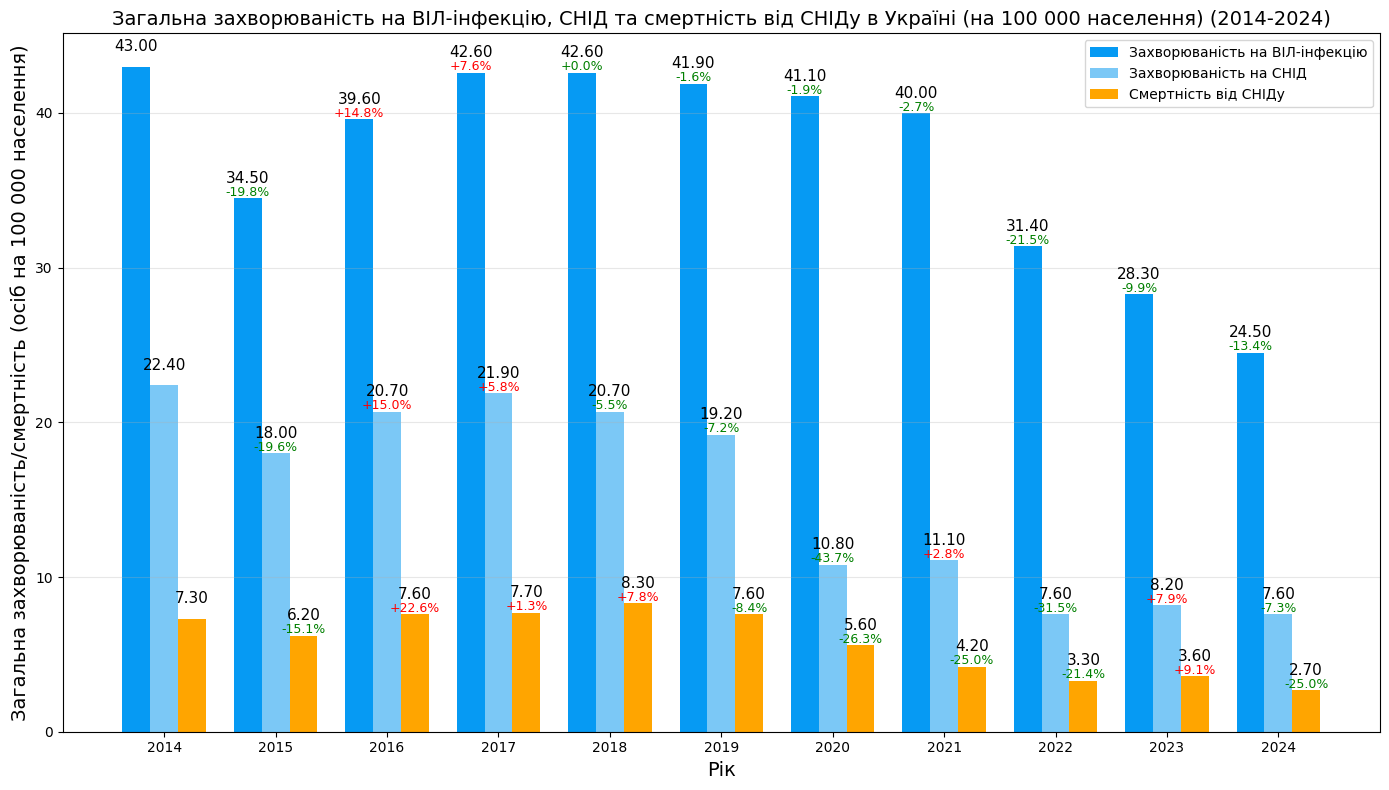

In [257]:
plot_yearly_rel_cases_deaths(data)

## 7.1 Завантаження геоданих України для побудови просторової карти

In [200]:
try:
    # Шлях до GeoJSON файлу
    geo_json_path = '/Users/konstantin/Documents/КПІ/ДИПЛОМ/ua.json'  # повний шлях
except Exception as e:
    print(f'{e}')

## 7.2 Карта захворюваності на ВІЛ по регіонах

In [201]:
def plot_ukraine_hiv_aids_map(data, geo_json_path, years=None):
    """
    Побудова карти України з рівнем захворюваності на ВІЛ та СНІД
    Parameters:
        data - DataFrame з даними
        geo_json_path - шлях до файлу з геоданими
        years - список років або діапазон (None - всі роки)
    """
    # Завантаження геоданих
    ukraine_geo = gpd.read_file(geo_json_path)
    
    # Словник для перетворення назв з GeoJSON у формат даних
    geo_to_data_names = {
        'UA71': 'Черкаська',
        'UA74': 'Чернігівська',
        'UA77': 'Чернівецька',
        'UA12': 'Дніпропетровська',
        'UA14': 'Донецька',
        'UA26': 'Івано-Франківська',
        'UA63': 'Харківська',
        'UA65': 'Херсонська',
        'UA68': 'Хмельницька',
        'UA30': 'Київська',
        'UA35': 'Кіровоградська',
        'UA09': 'Луганська',
        'UA46': 'Львівська',
        'UA48': 'Миколаївська',
        'UA51': 'Одеська',
        'UA53': 'Полтавська',
        'UA56': 'Рівненська',
        'UA59': 'Сумська',
        'UA61': 'Тернопільська',
        'UA05': 'Вінницька',
        'UA07': 'Волинська',
        'UA21': 'Закарпатська',
        'UA23': 'Запорізька',
        'UA18': 'Житомирська',
        'UA40': 'Севастополь',
        'UA32': 'Київ',
        'UA43': 'Крим'
    }
    
    # Додаємо новий стовпець з нормалізованими назвами
    ukraine_geo['name_uk'] = ukraine_geo['id'].map(geo_to_data_names)
    
    # Фільтрація даних за роками
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    
    if years is not None:
        if isinstance(years, int):
            years = [years]
        data = data[data['Year'].isin(years)]
        year_title = f"за {', '.join(map(str, sorted(years)))} р."
    else:
        year_title = "за 2014-2024 рр."
    
    # Підготовка даних
    hiv_aids_rates = data.groupby('Region')['Total_Cases_rate'].mean().reset_index()
    
    # Об'єднання даних
    merged_data = ukraine_geo.merge(hiv_aids_rates, 
                                  left_on='name_uk', 
                                  right_on='Region', 
                                  how='left')
    
    # Візуалізація
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Встановлюємо діапазон кольорів
    vmin, vmax = 0, merged_data['Total_Cases_rate'].max()
    
    merged_data.plot(column='Total_Cases_rate', 
                   ax=ax, 
                   legend=True,
                   cmap='Reds',
                   edgecolor='white',
                   linewidth=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
    
    # Підписи регіонів
    for idx, row in merged_data.iterrows():
        if pd.notna(row['Total_Cases_rate']):
            centroid = row['geometry'].centroid
            if row['name_uk'] != 'Київська':
                ax.annotate(text=f"{row['name_uk']}\n{row['Total_Cases_rate']:.1f}", 
                          xy=(centroid.x, centroid.y),
                          ha='center',
                          fontsize=9,
                          color='black')
            else:
                ax.annotate(text=f"{row['name_uk']}\n{row['Total_Cases_rate']:.1f}", 
                          xy=(centroid.x, centroid.y-0.3),
                          ha='center',
                          fontsize=9,
                          color='black')
    
    ax.set_title(f'Середньомісячний рівень захворюваності на ВІЛ-інфекцію та СНІД по регіонах України\n{year_title} (осіб на 100 000 населення)', 
                fontsize=16)
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(f'ukraine_hiv_aids_map_{years if years else "all"}.png', dpi=300, bbox_inches='tight')
    plt.show()

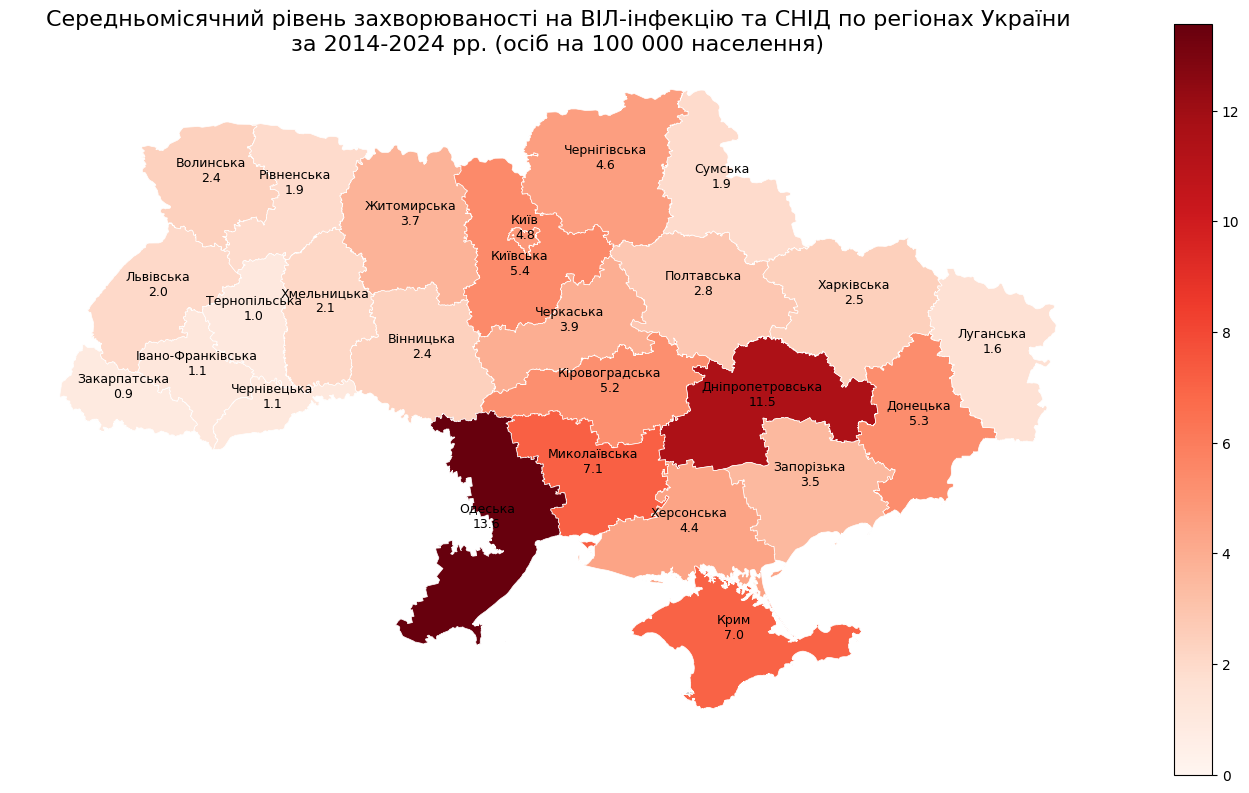

In [202]:
# Виклик функції для побудови карти
plot_ukraine_hiv_aids_map(data, geo_json_path)

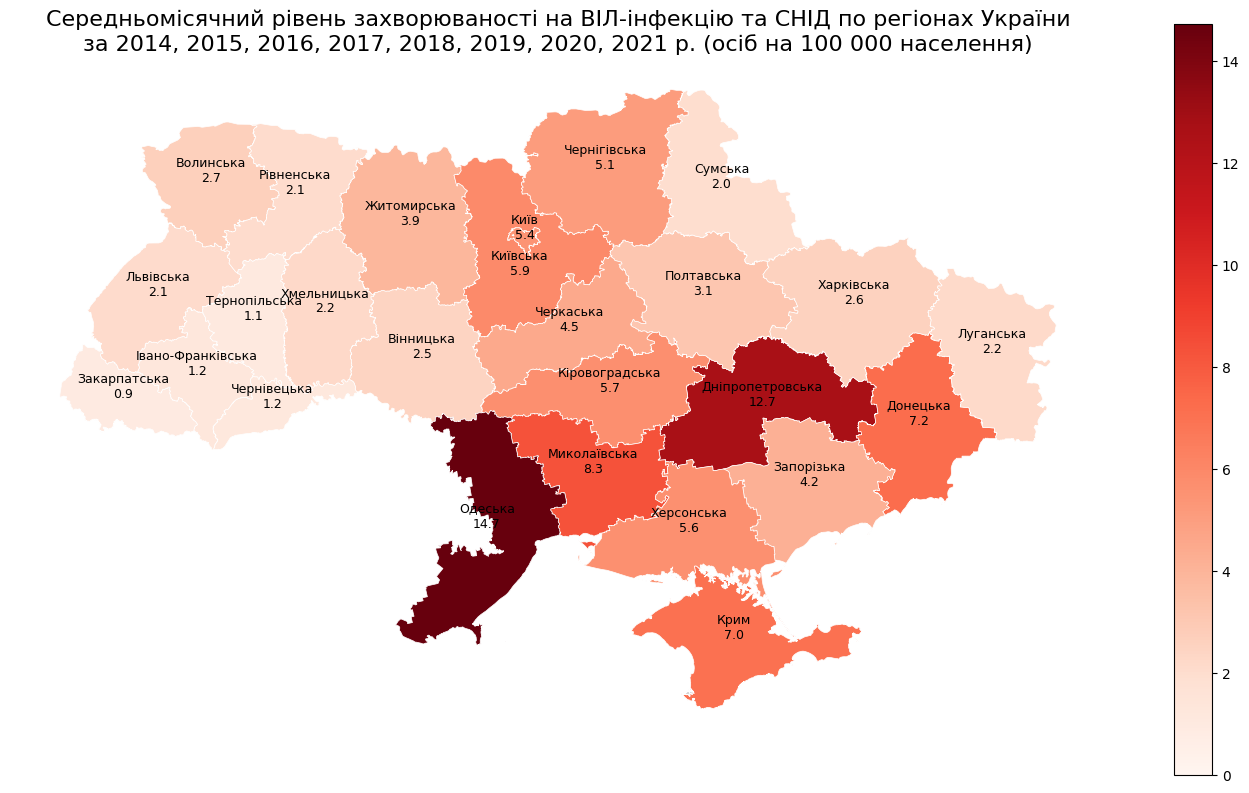

In [203]:
plot_ukraine_hiv_aids_map(data, geo_json_path, years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [204]:
def plot_ukraine_death_map(data, geo_json_path, years=None):
    """
    Побудова карти України з рівнем смертності від СНІДу (Death_Rate)
    Parameters:
        data - DataFrame з даними (має містити стовпець Death_Rate)
        geo_json_path - шлях до файлу з геоданими
        years - список років або діапазон (None - всі роки)
    """
    # Завантаження геоданих
    ukraine_geo = gpd.read_file(geo_json_path)
    
    # Словник для перетворення назв регіонів
    geo_to_data_names = {
        'UA71': 'Черкаська', 'UA74': 'Чернігівська', 'UA77': 'Чернівецька',
        'UA12': 'Дніпропетровська', 'UA14': 'Донецька', 'UA26': 'Івано-Франківська',
        'UA63': 'Харківська', 'UA65': 'Херсонська', 'UA68': 'Хмельницька',
        'UA30': 'Київська', 'UA35': 'Кіровоградська', 'UA09': 'Луганська',
        'UA46': 'Львівська', 'UA48': 'Миколаївська', 'UA51': 'Одеська',
        'UA53': 'Полтавська', 'UA56': 'Рівненська', 'UA59': 'Сумська',
        'UA61': 'Тернопільська', 'UA05': 'Вінницька', 'UA07': 'Волинська',
        'UA21': 'Закарпатська', 'UA23': 'Запорізька', 'UA18': 'Житомирська',
        'UA40': 'Севастополь', 'UA32': 'Київ', 'UA43': 'Крим'
    }
    
    ukraine_geo['name_uk'] = ukraine_geo['id'].map(geo_to_data_names)
    
    # Фільтрація даних за роками
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    
    if years is not None:
        if isinstance(years, int):
            years = [years]
        data = data[data['Year'].isin(years)]
        year_title = f"за {', '.join(map(str, sorted(years)))} р."
    else:
        year_title = "за 2014-2024 рр."
    
    # Підготовка даних
    death_rates = data.groupby('Region')['Death_Rate'].mean().reset_index()
    
    # Об'єднання з геоданими
    merged_data = ukraine_geo.merge(death_rates, 
                                  left_on='name_uk', 
                                  right_on='Region', 
                                  how='left')
    
    # Візуалізація
    fig, ax = plt.subplots(figsize=(14, 8))
    
    vmin, vmax = 0, merged_data['Death_Rate'].max()*1.1
    
    merged_data.plot(column='Death_Rate', 
                   ax=ax, 
                   legend=True,
                   cmap='Purples',
                   edgecolor='white',
                   linewidth=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   missing_kwds={'color': 'lightgrey', 'label': 'Немає даних'})
    
    # Підписи регіонів
    for idx, row in merged_data.iterrows():
        if pd.notna(row['Death_Rate']):
            centroid = row['geometry'].centroid
            offset = -0.3 if row['name_uk'] == 'Київська' else -0.1
            ax.annotate(text=f"{row['name_uk']}\n{row['Death_Rate']:.1f}", 
                      xy=(centroid.x, centroid.y + offset),
                      ha='center',
                      fontsize=9,
                      color='black')
    
    ax.set_title(f'Середньомісячний рівень смертності від СНІДу (на 100 000 населення)\n{year_title}', 
                fontsize=16)
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(f'ukraine_death_map_{years if years else "all"}.png', dpi=300, bbox_inches='tight')
    plt.show()

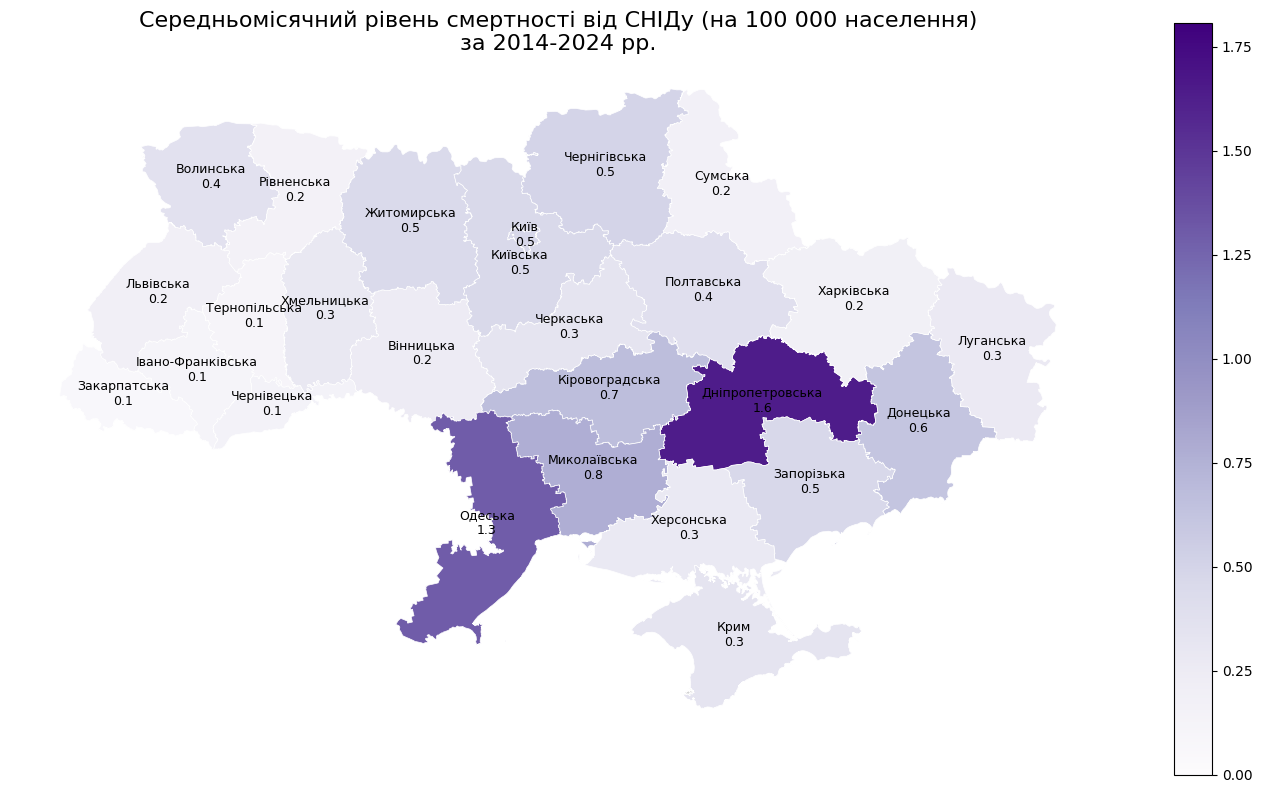

In [205]:
plot_ukraine_death_map(data, geo_json_path)

In [206]:
def plot_yearly_hiv_aids_maps(data, geo_json_path, years=range(2014, 2025)):
    """
    Побудова матриці карт захворюваності за кожен рік
    Parameters:
        data - DataFrame з даними
        geo_json_path - шлях до файлу з геоданими
        years - список або діапазон років (за замовчуванням 2014-2024)
    """
    # Завантаження геоданих
    ukraine_geo = gpd.read_file(geo_json_path)
    
    # Словник для перетворення назв з GeoJSON у формат даних
    geo_to_data_names = {
        'UA71': 'Черкаська',
        'UA74': 'Чернігівська',
        'UA77': 'Чернівецька',
        'UA12': 'Дніпропетровська',
        'UA14': 'Донецька',
        'UA26': 'Івано-Франківська',
        'UA63': 'Харківська',
        'UA65': 'Херсонська',
        'UA68': 'Хмельницька',
        'UA30': 'Київська',
        'UA35': 'Кіровоградська',
        'UA09': 'Луганська',
        'UA46': 'Львівська',
        'UA48': 'Миколаївська',
        'UA51': 'Одеська',
        'UA53': 'Полтавська',
        'UA56': 'Рівненська',
        'UA59': 'Сумська',
        'UA61': 'Тернопільська',
        'UA05': 'Вінницька',
        'UA07': 'Волинська',
        'UA21': 'Закарпатська',
        'UA23': 'Запорізька',
        'UA18': 'Житомирська',
        'UA40': 'Севастополь',
        'UA32': 'Київ',
        'UA43': 'Крим'
    }
    
    # Додаємо новий стовпець з нормалізованими назвами
    ukraine_geo['name_uk'] = ukraine_geo['id'].map(geo_to_data_names)
    
    # Підготовка даних
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    data = data[data['Year'].isin(years)]
    
    # Створюємо фігуру з підграфіками
    n_years = len(years)
    n_cols = 3
    n_rows = (n_years + n_cols - 1) // n_cols
    
    # Зменшуємо вертикальні відступи між рядами
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3*n_rows),
                           gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
    axes = axes.flatten()  # Перетворюємо матрицю у плоский масив
    
    # Знаходимо загальний діапазон значень для однакової кольорової шкали
    vmin = 0
    vmax = data['Total_Cases_rate'].max()
    
    for i, year in enumerate(sorted(years)):
        ax = axes[i]
        
        # Фільтруємо дані за роком
        year_data = data[data['Year'] == year]
        hiv_aids_rates = year_data.groupby('Region')['Total_Cases_rate'].mean().reset_index()
        
        # Об'єднання даних hiv_rates з геомасивом
        merged_data = ukraine_geo.merge(hiv_aids_rates, 
                                      left_on='name_uk', 
                                      right_on='Region', 
                                      how='left')
        
        # Відображення карти
        merged_data.plot(column='Total_Cases_rate', 
                       ax=ax, 
                       cmap='Reds',
                       edgecolor='white',
                       linewidth=0.3,
                       vmin=vmin,
                       vmax=vmax,
                       missing_kwds={
                           'color': 'lightgrey',
                           'label': 'Немає даних'
                       })
        
        # Підписи регіонів
        for idx, row in merged_data.iterrows():
            if pd.notna(row['Total_Cases_rate']):
                centroid = row['geometry'].centroid
                if row['name_uk'] == 'Київська':
                    ax.annotate(text=f"{row['Total_Cases_rate']:.1f}", 
                              xy=(centroid.x, centroid.y-0.3),
                              ha='center',
                              fontsize=6,
                              color='black')
                else:
                    ax.annotate(text=f"{row['Total_Cases_rate']:.1f}", 
                              xy=(centroid.x, centroid.y-0.1),
                              ha='center',
                              fontsize=6,
                              color='black')
        
        ax.set_title(str(year), fontsize=8, pad=1)  # відступ заголовка
        ax.set_axis_off()
    
    # Приховуємо зайві підграфіки
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # загальна кольорова шкала внизу
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Середньомісячна захворюваність на ВІЛ-інфекцію на СНІД (на 100 000 населення)', fontsize=8)
    
    fig.suptitle('Динаміка середьномісячного рівня захворюваності на ВІЛ-інфекцію та СНІД по регіонах України (на 100 000 населення)', 
                fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Залишаємо місце для кольорової шкали
    plt.savefig('ukraine_hiv_aids_yearly_maps.png', dpi=300, bbox_inches='tight')
    plt.show()

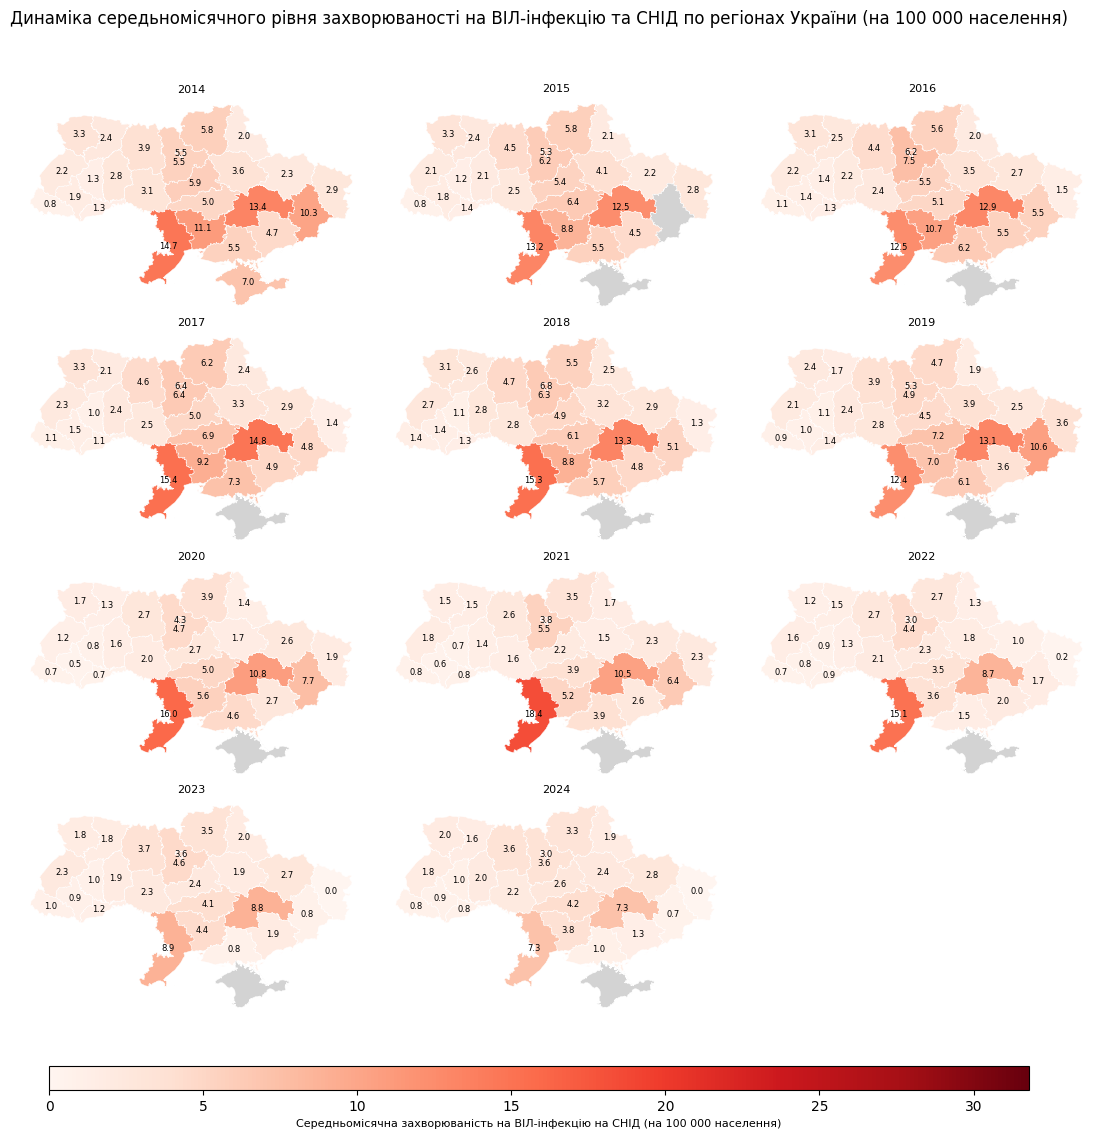

In [207]:
# Для всіх років (2014-2024)
plot_yearly_hiv_aids_maps(data, 'ua.json')

In [208]:
def plot_yearly_death_maps(data, geo_json_path, years=range(2014, 2025)):
    """
    Побудова матриці карт середньомісячної смертності за кожен рік
    Parameters:
        data - DataFrame з даними
        geo_json_path - шлях до файлу з геоданими
        years - список або діапазон років (за замовчуванням 2014-2024)
    """
    # Завантаження геоданих
    ukraine_geo = gpd.read_file(geo_json_path)
    
    # Словник для перетворення назв з GeoJSON у формат даних
    geo_to_data_names = {
        'UA71': 'Черкаська',
        'UA74': 'Чернігівська',
        'UA77': 'Чернівецька',
        'UA12': 'Дніпропетровська',
        'UA14': 'Донецька',
        'UA26': 'Івано-Франківська',
        'UA63': 'Харківська',
        'UA65': 'Херсонська',
        'UA68': 'Хмельницька',
        'UA30': 'Київська',
        'UA35': 'Кіровоградська',
        'UA09': 'Луганська',
        'UA46': 'Львівська',
        'UA48': 'Миколаївська',
        'UA51': 'Одеська',
        'UA53': 'Полтавська',
        'UA56': 'Рівненська',
        'UA59': 'Сумська',
        'UA61': 'Тернопільська',
        'UA05': 'Вінницька',
        'UA07': 'Волинська',
        'UA21': 'Закарпатська',
        'UA23': 'Запорізька',
        'UA18': 'Житомирська',
        'UA40': 'Севастополь',
        'UA32': 'Київ',
        'UA43': 'Крим'
    }
    
    # Додаємо новий стовпець з нормалізованими назвами
    ukraine_geo['name_uk'] = ukraine_geo['id'].map(geo_to_data_names)
    
    # Підготовка даних
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    data = data[data['Year'].isin(years)]
    
    # Створюємо фігуру з підграфіками
    n_years = len(years)
    n_cols = 3
    n_rows = (n_years + n_cols - 1) // n_cols
    
    # Налаштування відступів
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3*n_rows),
                           gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
    axes = axes.flatten()
    
    # Знаходимо загальний діапазон значень для кольорової шкали
    vmin = 0
    vmax = data['Death_Rate'].max()*0.4
    
    for i, year in enumerate(sorted(years)):
        ax = axes[i]
        
        # Фільтруємо дані за роком
        year_data = data[data['Year'] == year]
        death_rates = year_data.groupby('Region')['Death_Rate'].mean().reset_index()
        
        # Об'єднання даних
        merged_data = ukraine_geo.merge(death_rates, 
                                      left_on='name_uk', 
                                      right_on='Region', 
                                      how='left')
        
        # Відображення карти
        merged_data.plot(column='Death_Rate', 
                       ax=ax, 
                       cmap='Purples',  # Інша кольорова схема для смертності
                       edgecolor='white',
                       linewidth=0.3,
                       vmin=vmin,
                       vmax=vmax,
                       missing_kwds={
                           'color': 'lightgrey',
                           'label': 'Немає даних'
                       })
        
        # Підписи регіонів
        for idx, row in merged_data.iterrows():
            if pd.notna(row['Death_Rate']):
                centroid = row['geometry'].centroid
                if row['name_uk'] == 'Київська':
                    ax.annotate(text=f"{row['Death_Rate']:.1f}", 
                              xy=(centroid.x, centroid.y-0.3),
                              ha='center',
                              fontsize=6,
                              color='black')
                else:
                    ax.annotate(text=f"{row['Death_Rate']:.1f}", 
                              xy=(centroid.x, centroid.y-0.1),
                              ha='center',
                              fontsize=6,
                              color='black')
        
        ax.set_title(str(year), fontsize=8, pad=1)
        ax.set_axis_off()
    
    # Приховуємо зайві підграфіки
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Додаємо загальну кольорову шкалу внизу
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Середньомісячний рівень смертності від СНІД (на 100 000 населення)', fontsize=8)
    
    fig.suptitle('Динаміка середньомісячного рівня смертності від СНІДу по регіонах України (на 100 000 населення)', 
                fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig('ukraine_death_yearly_maps.png', dpi=300, bbox_inches='tight')
    plt.show()

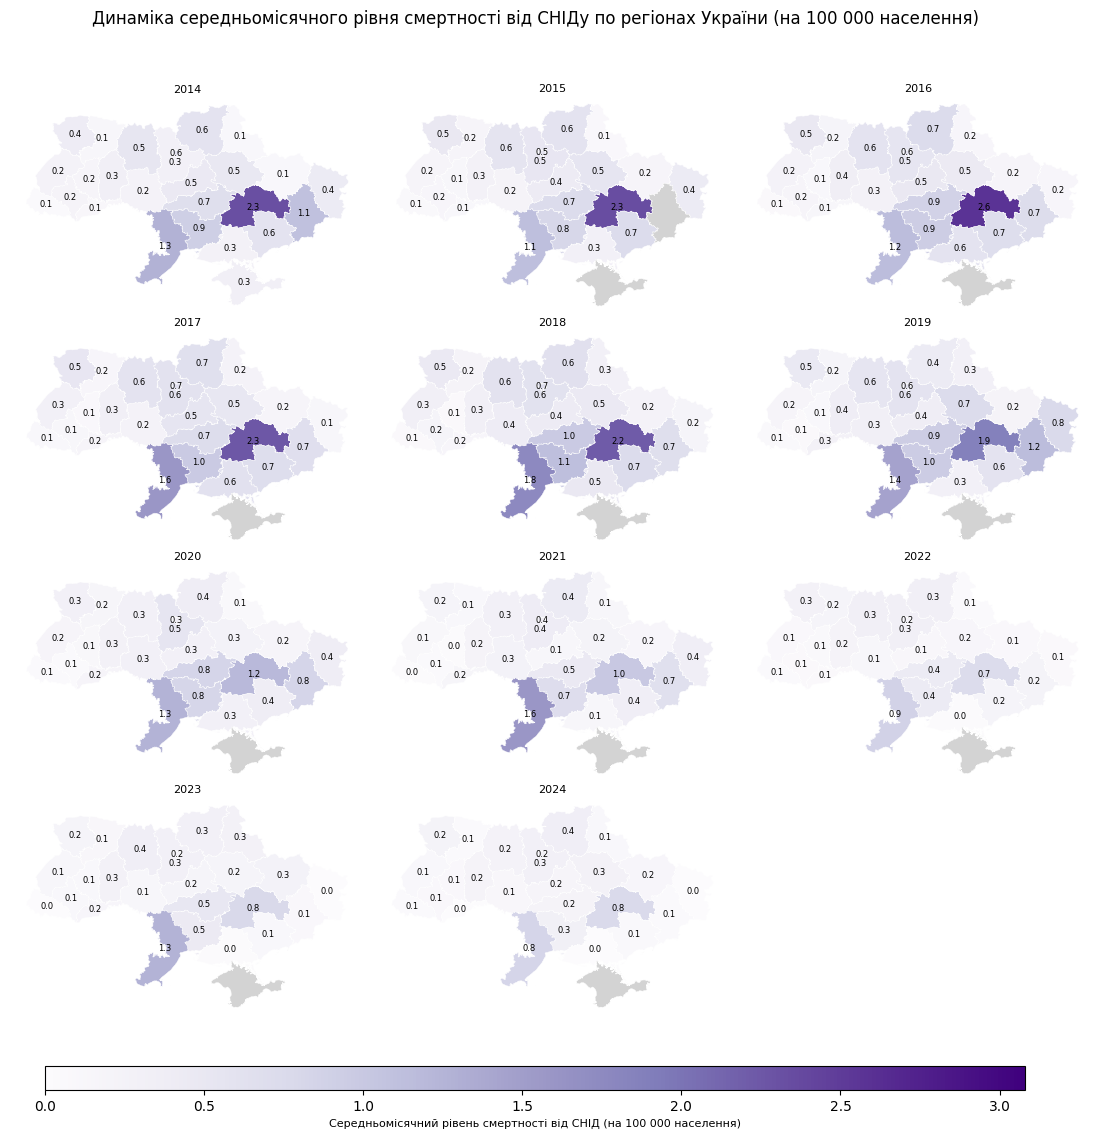

In [209]:
plot_yearly_death_maps(data, 'ua.json')